# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [49]:
from folktables.acs import adult_filter
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import pandas as pd

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:

sex_index = features.columns.tolist().index('SEX_Female')
print(sex_index)
race_index = features.columns.tolist().index('RAC1P_Black or African American alone')
print(race_index)

54
55


In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(features, labels, groups, test_size=0.1, random_state=0)


In [142]:
#######
# YOUR CODE
#######
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
#groups
from sklearn.model_selection import cross_val_score

numeric_features = ["AGEP","WKHP", "PWGTP"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_train,y_train.values.ravel())

cv = KFold(n_splits=(100))
scores = cross_val_score(clf, X_test, y_test.values.ravel(), cv = cv)
print(scores)

[0.86153846 0.83076923 0.84615385 0.82307692 0.80769231 0.84615385
 0.77692308 0.79230769 0.8        0.82307692 0.8        0.77692308
 0.76153846 0.76153846 0.76923077 0.81538462 0.76153846 0.82307692
 0.80769231 0.83846154 0.80769231 0.86153846 0.76923077 0.77692308
 0.75384615 0.8        0.86153846 0.83846154 0.8        0.79230769
 0.76153846 0.82307692 0.82307692 0.76923077 0.77692308 0.80769231
 0.80769231 0.83846154 0.81538462 0.76923077 0.83076923 0.76153846
 0.8        0.81538462 0.84615385 0.73846154 0.74615385 0.89230769
 0.77692308 0.75384615 0.74615385 0.83076923 0.82307692 0.84615385
 0.80769231 0.81538462 0.8        0.81395349 0.79069767 0.82945736
 0.80620155 0.81395349 0.82945736 0.7751938  0.79069767 0.82945736
 0.75968992 0.81395349 0.7751938  0.81395349 0.72868217 0.82170543
 0.76744186 0.75193798 0.86821705 0.82170543 0.75193798 0.81395349
 0.82170543 0.78294574 0.79069767 0.79844961 0.86821705 0.78294574
 0.8372093  0.86046512 0.76744186 0.80620155 0.7751938  0.8217

In [65]:

### Get Females, Males, Blacks and whites 
### Should we further subdevide them??

female = X_test.loc[X_test["SEX_Female"] == 1.0]
male = X_test.loc[X_test["SEX_Female"] == 0.0]
blacks = X_test.loc[X_test["RAC1P_Black or African American alone"] == 1.0]
whites = X_test.loc[X_test["RAC1P_Black or African American alone"] == 0.0]

<Axes: ylabel='Count'>

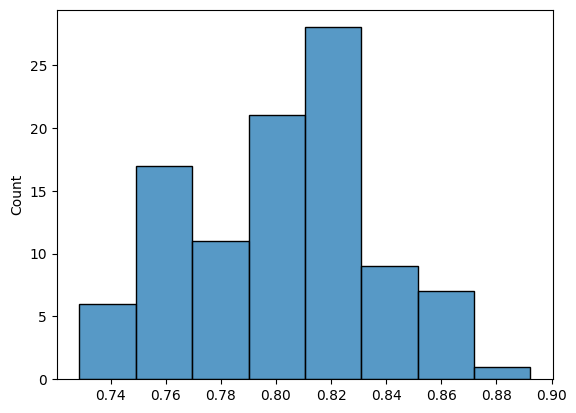

In [143]:
import seaborn as sns

sns.histplot(scores)

In [144]:
X_test.loc[groups_test[groups_test["SEX"] == 2].index.tolist()]

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
72476,63.0,50.0,99.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
25524,36.0,30.0,67.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
57955,32.0,40.0,66.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
119330,25.0,40.0,250.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6278,54.0,45.0,90.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62379,48.0,40.0,61.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2967,21.0,30.0,99.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
57657,65.0,60.0,141.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
60385,27.0,40.0,67.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [202]:
groups_test.loc[groups_test["SEX"]==1]["SEX"].values
print(set(groups_test["RAC1P"].values))
#groups_test["SEX" == 1]

{1, 2}


1
2


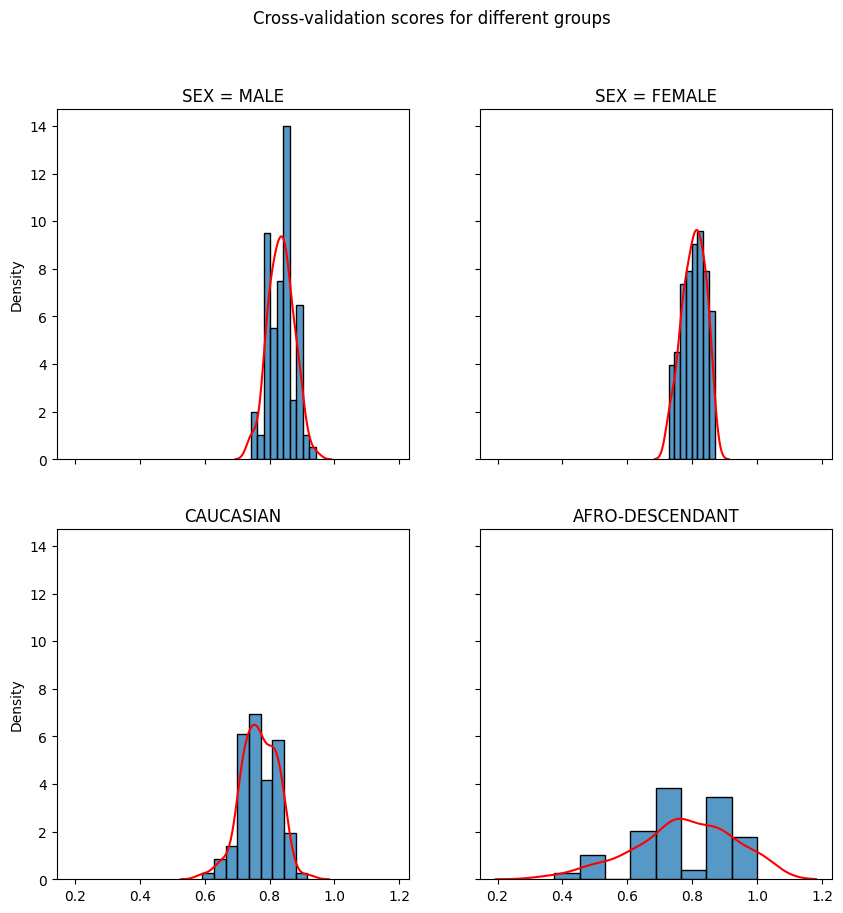

In [146]:
# score when split the dataset
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2,2, figsize=(10,10), sharey=True, sharex=True)

for i in range(1,3):
    print(i)
    score_sex = cross_val_score(clf, X_test.loc[groups_test[groups_test["SEX"] == i].index.tolist()], 
                                y_test.loc[groups_test[groups_test["SEX"] == i].index.tolist()].values.ravel(), 
                                cv = cv)
    score_race = cross_val_score(clf, X_test.loc[groups_test[groups_test["RAC1P"] == i].index.tolist()], 
                                y_test.loc[groups_test[groups_test["RAC1P"] == i].index.tolist()].values.ravel(), 
                                cv = cv)
    
    sns.histplot(score_sex, ax=ax[i-1, 0], kde=False, stat="density", line_kws={"color":"red"})
    sns.kdeplot(score_sex, ax=ax[i-1, 0], color="red")
    sns.histplot(score_race, ax=ax[i-1, 1], kde=False, stat="density", line_kws={"color":"red"})
    sns.kdeplot(score_race, ax=ax[i-1, 1], color="red")

ax[0,0].set_title("SEX = MALE")
ax[0,1].set_title("SEX = FEMALE")


ax[1,0].set_title("CAUCASIAN")
ax[1,1].set_title("AFRO-DESCENDANT")


plt.suptitle("Cross-validation scores for different groups")
plt.show()


In [147]:
### Get Females, Males, Blacks and whites 
### Should we further subdevide them??

female = X_test.loc[X_test["SEX_Female"] == 1.0]
male = X_test.loc[X_test["SEX_Female"] == 0.0]
blacks = X_test.loc[X_test["RAC1P_Black or African American alone"] == 1.0]
whites = X_test.loc[X_test["RAC1P_Black or African American alone"] == 0.0]

#print(list(female.index))

y_index = list(y_test.index)
def find_responding_y_test(data):
    resulting_list = []
    for i in list(data.index):
        if i in y_index:
            resulting_list.append(int(i))
    return resulting_list

f_resulting_index = find_responding_y_test(female)
y_test_female = y_test.loc[f_resulting_index]

m_resulting_index = find_responding_y_test(male)
y_test_male = y_test.loc[m_resulting_index]

b_resulting_index = find_responding_y_test(blacks)
y_test_black = y_test.loc[b_resulting_index]

w_resulting_index = find_responding_y_test(whites)
y_test_white = y_test.loc[w_resulting_index]


In [182]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

In [162]:
#print("Female", clf.score(female, y_test_female))
#print("Male", clf.score(male, y_test_male))
#print("Black", clf.score(blacks, y_test_black))
#print("White", clf.score(whites, y_test_white))

p_f = clf.predict(female)#, y_test_female)
p_m = clf.predict(male)#, y_test_male)
p_b = clf.predict(blacks)#, y_test_black)
p_w = clf.predict(whites)#, y_test_white)


confusion_matrix_female = metrics.confusion_matrix(p_f, y_test_female)
confusion_matrix_male = metrics.confusion_matrix(p_m, y_test_male)
confusion_matrix_whites = metrics.confusion_matrix(p_w, y_test_white)
confusion_matrix_blacks = metrics.confusion_matrix(p_b, y_test_black)

print(confusion_matrix_female )


[[1230  349]
 [1027 3359]]


## Accuracy

In [189]:
print("Accuracy_Score Male: ", round(accuracy_score(y_test_male,p_m ),2))
print("Accuracy_Score Female: ", round(accuracy_score(y_test_female,p_f ),2))
print("Accuracy_Score Whites: ", round(accuracy_score(y_test_white,p_w ),2))
print("Accuracy_Score Blacks: ", round(accuracy_score(y_test_black,p_b ),2))

Accuracy_Score Male:  0.83
Accuracy_Score Female:  0.77
Accuracy_Score Whites:  0.8
Accuracy_Score Blacks:  0.77


## F1 Score

In [192]:
print("F1_Score Male: ", round(f1_score(y_test_male,p_m ),2))
print("F1_Score Female: ", round(f1_score(y_test_female,p_f ),2))
print("F1_Score Whites: ", round(f1_score(y_test_white,p_w ),2))
print("F1_Score Blacks: ", round(f1_score(y_test_black,p_b ),2))

F1_Score Male:  0.89
F1_Score Female:  0.83
F1_Score Whites:  0.87
F1_Score Blacks:  0.83


## Matthews Correlation
-  The Matthews correlation coefficient is more informative than F1 score and accuracy in evaluating binary classification problems, because it takes into account the balance ratios of the four confusion matrix categories (true positives, true negatives, false positives, false negatives)

In [196]:
print("Matthews_corrcoef Male: ", round(matthews_corrcoef(y_test_male,p_m ),5))
print("Matthews_corrcoef Female: ", round(matthews_corrcoef(y_test_female,p_f ),5))
print("Matthews_corrcoef Whites: ", round(matthews_corrcoef(y_test_white,p_w ),5))
print("Matthews_corrcoef Blacks: ", round(matthews_corrcoef(y_test_black,p_b ),5))

Matthews_corrcoef Male:  0.51439
Matthews_corrcoef Female:  0.49561
Matthews_corrcoef Whites:  0.51155
Matthews_corrcoef Blacks:  0.51099


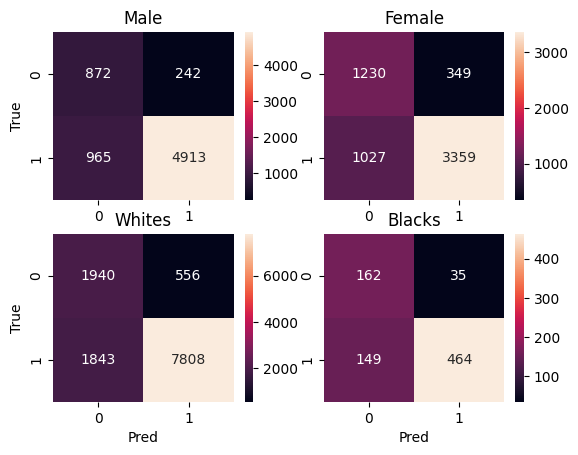

In [174]:
fig, (ax1, ax2) = plt.subplots(2,2)
g1= sns.heatmap(confusion_matrix_male, annot=True, fmt='g', ax=ax1[0])
g1.set_ylabel("True")
g1.set_title("Male")
g2= sns.heatmap(confusion_matrix_female, annot=True, fmt='g', ax=ax1[1])
#g1.set_xlabel("True")
g2.set_title("Female")
g3= sns.heatmap(confusion_matrix_whites, annot=True, fmt='g', ax=ax2[0])
g3.set_ylabel("True")
g3.set_xlabel("Pred")
g3.set_title("Whites")
g4= sns.heatmap(confusion_matrix_blacks, annot=True, fmt='g', ax=ax2[1])
g4.set_xlabel("Pred")
g4.set_title("Blacks")
plt.show()



### Determine significant difference between the classification methods